# Prosper Loan Data
## by Alejandro Rodriguez Martinez

## Preliminary Wrangling

> This dataset contains information on loans given to individuals. There are 113937 entries with 81 variables each. For this analysis only a subset of them will be chosen. Interesting variables include Borrower's APR, Loan Status or Credit score to name a few

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import norm
%matplotlib inline

Let's load the dataset and get an overview of the main properties for the data.

In [2]:
loan = pd.read_csv('prosperLoanData.csv')
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             113937 non-null object
ListingNumber                          113937 non-null int64
ListingCreationDate                    113937 non-null object
CreditGrade                            28953 non-null object
Term                                   113937 non-null int64
LoanStatus                             113937 non-null object
ClosedDate                             55089 non-null object
BorrowerAPR                            113912 non-null float64
BorrowerRate                           113937 non-null float64
LenderYield                            113937 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                84853 non-null float64
ProsperRating (Alpha) 

There are a few columns that are IDs, these can be removed. IDs may be of use when joining different dataframes or when drawing conclusions for specific individuals. However this analysis is rather on the aggregated side. The idea is to find out relationship between variables in the data set as a whole and so IDs are of no use in this case. However before removing unique IDs, let's make sure there are no duplicates

In [4]:
listingkeyfilt= [i for i,j in loan.ListingKey.value_counts().iteritems() if j > 1]
len(listingkeyfilt)   # ProsperScore seems to be not reliable

827

It seems that there are many duplicates for column ListingKey. However when using pandas duplicated() method, pandas seems to suggest that there are no duplicates.


In [5]:
sum(loan.duplicated())

0

This leads me to think that there are columns that are different for the same ListingKey ID. Visual inspection in Excel reveals that **ProsperScore** column contains different numbers for what otherwise would be an duplicate entry. To me it doesn't make sense to allocate different risk scores to the same data. Therefore this column seems unreliable and it will be a column we will drop for our analysis.

In [36]:
loan_clean = loan.drop('ProsperScore',axis=1)
sum(loan_clean.ListingKey.duplicated())

871

It can be observed above that now there are 871 rows that are duplicated and thus can be removed. Let's do so

In [37]:
print(loan_clean.shape[0])
loan_clean.drop_duplicates(inplace=True)
print(loan_clean.shape[0])

113937
113066


Other column that show IDs are: ListingNumber, LoanKey, LoanNumber. Let's remove them

In [38]:
for colnametoDrop in ['ListingKey','ListingNumber', 'LoanKey', 'LoanNumber']:
    loan_clean.drop(colnametoDrop,axis=1,inplace=True)
loan_clean.shape

(113066, 76)

MemberKey and GroupKey columns are not unique, but we are not interested in particular customers, so these columns can be removed as well

In [39]:
loan_clean.drop(['MemberKey','GroupKey'],axis=1,inplace=True)
loan_clean.shape

(113066, 74)

There are some other columns that contain too many NaN values, when deciding which columns to analyse the ones that contain less information will be discarded. However since there are so many columns that need to be removed, it may be more sensible to select the subset of columns that we want to analyse.
For starters, let's narrow down the number of variables to 17 columns that we can group in the following manner   

**Numerical Discrete**
- 'EmploymentStatusDuration' 
- 'CreditScoreRangeUpper'
- 'DelinquenciesLast7Years'
- 'RevolvingCreditBalance'
- 'AvailableBankcardCredit'
- 'LoanOriginalAmount'  

**Numerical Continuous**
- 'BorrowerAPR' 
- 'LenderYield'
- 'DebtToIncomeRatio'

**Categorical/ Nominal**
- 'EmploymentStatus'    -  9 categories
- 'IsBorrowerHomeowner' - 2 categories
- 'LoanStatus'    - 12 categories    

**Ordinal**
- 'Term'
- 'IncomeRange'
- 'CreditGrade'                         
- 'ProsperRating (Alpha)'               

In [40]:
columnsToKeep = ['EmploymentStatusDuration','CreditScoreRangeUpper','DelinquenciesLast7Years','RevolvingCreditBalance','AvailableBankcardCredit','LoanOriginalAmount','BorrowerAPR','LenderYield','DebtToIncomeRatio','EmploymentStatus','IsBorrowerHomeowner','LoanStatus','Term','IncomeRange','CreditGrade','ProsperRating (Alpha)']
loan_clean.drop([x for x in loan_clean.columns if x not in columnsToKeep],axis=1,inplace=True)
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113936
Data columns (total 16 columns):
CreditGrade                 28953 non-null object
Term                        113066 non-null int64
LoanStatus                  113066 non-null object
BorrowerAPR                 113041 non-null float64
LenderYield                 113066 non-null float64
ProsperRating (Alpha)       83982 non-null object
EmploymentStatus            110811 non-null object
EmploymentStatusDuration    105441 non-null float64
IsBorrowerHomeowner         113066 non-null bool
CreditScoreRangeUpper       112475 non-null float64
DelinquenciesLast7Years     112076 non-null float64
RevolvingCreditBalance      105462 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           104594 non-null float64
IncomeRange                 113066 non-null object
LoanOriginalAmount          113066 non-null int64
dtypes: bool(1), float64(8), int64(2), object(5)
memory usage: 13.9+ MB

Interestingly, the two columns that contain fewer entries, namely Credit Grade and Prosper Rating, complement one another. It can be seen below that they both never contain values for the same entry and only a few entries are missing both variables. 

In [41]:
print('Both columns are null at the same time: {}'.format(sum(loan_clean['CreditGrade'].isna() & loan_clean['ProsperRating (Alpha)'].isna())))
print('Both columns are not null at the same time: {}'.format(sum(loan_clean['CreditGrade'].notna() & loan_clean['ProsperRating (Alpha)'].notna())))

Both columns are null at the same time: 131
Both columns are not null at the same time: 0


Therefore we can join both columns into one, let's keep the name credit grade

In [42]:
loan_clean['CreditGrade'].where(loan_clean['CreditGrade'].notna(),loan_clean['ProsperRating (Alpha)'],inplace=True)
loan_clean.drop('ProsperRating (Alpha)',axis=1,inplace=True)
print(loan_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113936
Data columns (total 15 columns):
CreditGrade                 112935 non-null object
Term                        113066 non-null int64
LoanStatus                  113066 non-null object
BorrowerAPR                 113041 non-null float64
LenderYield                 113066 non-null float64
EmploymentStatus            110811 non-null object
EmploymentStatusDuration    105441 non-null float64
IsBorrowerHomeowner         113066 non-null bool
CreditScoreRangeUpper       112475 non-null float64
DelinquenciesLast7Years     112076 non-null float64
RevolvingCreditBalance      105462 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           104594 non-null float64
IncomeRange                 113066 non-null object
LoanOriginalAmount          113066 non-null int64
dtypes: bool(1), float64(8), int64(2), object(4)
memory usage: 13.0+ MB
None


Both Ordinal and categorical/nominal data could be casted as CategoricalDType. In this way it's clearer which variables are categorical and which ones are not.

In [43]:
loan_clean.CreditGrade.value_counts()
ordinal_var_dict = {'CreditGrade': ['NC','HR','E','D','C','B','A','AA'],
                    'Term':[12,36,60],
                    'IncomeRange':['Not displayed','Not employed','$0','$1-24,999','$25,000-49,999','$50,000-74,999','$75,000-99,999','$100,000+']}

for var in ordinal_var_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        loan_clean[var] = loan_clean[var].astype(ordered_var)
    else: # pre-v0.21
        loan_clean[var] = loan_clean[var].astype('category', ordered = True,
                                             categories = ordinal_var_dict[var])
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113936
Data columns (total 15 columns):
CreditGrade                 112935 non-null category
Term                        113066 non-null category
LoanStatus                  113066 non-null object
BorrowerAPR                 113041 non-null float64
LenderYield                 113066 non-null float64
EmploymentStatus            110811 non-null object
EmploymentStatusDuration    105441 non-null float64
IsBorrowerHomeowner         113066 non-null bool
CreditScoreRangeUpper       112475 non-null float64
DelinquenciesLast7Years     112076 non-null float64
RevolvingCreditBalance      105462 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           104594 non-null float64
IncomeRange                 113066 non-null category
LoanOriginalAmount          113066 non-null int64
dtypes: bool(1), category(3), float64(8), int64(1), object(2)
memory usage: 10.8+ MB


It seems that there are some missing entries for some columns. Let's inspect *AvailableBankcardCredit* for example. This will help us determine whether those entries are candidates to remove or on the other hand they follow an specified pattern. Let's display a slice of them

In [44]:
 loan_clean[loan_clean.AvailableBankcardCredit.isna()].sample(20)

,CreditGrade,Term,LoanStatus,BorrowerAPR,LenderYield,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CreditScoreRangeUpper,DelinquenciesLast7Years,RevolvingCreditBalance,AvailableBankcardCredit,DebtToIncomeRatio,IncomeRange,LoanOriginalAmount
79984,A,36,Completed,0.10642,0.0945,Not available,NaN,True,739.0,0.0,NaN,NaN,0.26000,Not displayed,5000
33533,A,36,Completed,0.11749,0.0950,Not available,NaN,True,739.0,0.0,NaN,NaN,0.13000,Not displayed,1000
48366,B,36,Completed,0.09678,0.0745,Not available,NaN,False,719.0,0.0,NaN,NaN,0.06000,Not displayed,1000
44125,AA,36,Completed,0.10391,0.0870,NaN,NaN,True,779.0,NaN,NaN,NaN,0.05000,Not displayed,10000
84156,D,36,Completed,0.15565,0.1400,NaN,NaN,False,639.0,NaN,NaN,NaN,0.01000,Not displayed,1675
45509,E,36,Defaulted,0.23196,0.2095,Not available,NaN,False,559.0,4.0,NaN,NaN,0.06000,Not displayed,2500
63873,A,36,Completed,0.10943,0.0950,Not available,NaN,False,739.0,0.0,NaN,NaN,0.13000,Not displayed,6001
26457,E,36,Completed,0.25295,0.2279,NaN,NaN,False,559.0,16.0,NaN,NaN,0.19000,Not displayed,5000
18485,D,36,Completed,0.10692,0.0875,NaN,NaN,False,NaN,NaN,NaN,NaN,0.50872,Not displayed,7000
102167,A,36,Completed,0.09688,0.0850,Not available,NaN,False,759.0,0.0,NaN,NaN,0.07000,Not displayed,5000


In [45]:
 loan_clean[loan_clean.AvailableBankcardCredit.isna()].Term.value_counts()

36    7544
60       0
12       0
Name: Term, dtype: int64

It seems that those entries that contain missing values for bankcard credit also contain missing values for some other columns. Also, it seems that it can be safe to rename NaN for Not available in **EmploymentStatus** column. Also notice that all entries that do not contain information for AvailableBankcardCredit correspond to loans on 36-month term... This is perhaps something to be wary about when drawing conclusions. However, for this analysis and bearing in mind that there are many more entries for 36-month loans that for any of the other two categories, then let's remove these rows.
Another thing to note is that CreditGrade already contains a NaN value which is NC


In [46]:
loan_clean.EmploymentStatus.replace(np.nan,'Not available',inplace=True)
loan_clean.CreditGrade.replace(np.nan,'NC',inplace=True)
loan_clean.drop(loan_clean[loan_clean.AvailableBankcardCredit.isna()].index,axis=0,inplace=True)
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105522 entries, 0 to 113936
Data columns (total 15 columns):
CreditGrade                 105522 non-null category
Term                        105522 non-null category
LoanStatus                  105522 non-null object
BorrowerAPR                 105522 non-null float64
LenderYield                 105522 non-null float64
EmploymentStatus            105522 non-null object
EmploymentStatusDuration    105439 non-null float64
IsBorrowerHomeowner         105522 non-null bool
CreditScoreRangeUpper       105522 non-null float64
DelinquenciesLast7Years     105500 non-null float64
RevolvingCreditBalance      105462 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           97172 non-null float64
IncomeRange                 105522 non-null category
LoanOriginalAmount          105522 non-null int64
dtypes: bool(1), category(3), float64(8), int64(1), object(2)
memory usage: 10.1+ MB


EmploymentStatusDuration, RevolvingCreditBalance, DeliquenciesLast7Years and DebtToIncomeRatio are likely to impact the CreditGrade... Since all entries have an associated CreditGrade let's fill the missing gaps with the average value for the creditgrade group

In [47]:
colToFil = ['EmploymentStatusDuration', 'RevolvingCreditBalance', 'DelinquenciesLast7Years','DebtToIncomeRatio']
for col in colToFil:
    dummyValues = loan_clean.groupby('CreditGrade').mean().reset_index()[['CreditGrade',col]]
    valuesOnGrade = loan_clean[loan_clean[col].isna()].merge(dummyValues,how='left',on='CreditGrade')['{}_y'.format(col)]
    indexesToWrite = loan_clean[loan_clean[col].isna()].index
    loan_clean.loc[indexesToWrite,col] = valuesOnGrade.values
    loan_clean[loan_clean[col].isna()]
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105522 entries, 0 to 113936
Data columns (total 15 columns):
CreditGrade                 105522 non-null category
Term                        105522 non-null category
LoanStatus                  105522 non-null object
BorrowerAPR                 105522 non-null float64
LenderYield                 105522 non-null float64
EmploymentStatus            105522 non-null object
EmploymentStatusDuration    105522 non-null float64
IsBorrowerHomeowner         105522 non-null bool
CreditScoreRangeUpper       105522 non-null float64
DelinquenciesLast7Years     105522 non-null float64
RevolvingCreditBalance      105522 non-null float64
AvailableBankcardCredit     105522 non-null float64
DebtToIncomeRatio           105522 non-null float64
IncomeRange                 105522 non-null category
LoanOriginalAmount          105522 non-null int64
dtypes: bool(1), category(3), float64(8), int64(1), object(2)
memory usage: 15.1+ MB


Now, there are no more missing entries. Discrete values can therefore be converted to int

In [48]:
loan_clean.EmploymentStatusDuration = loan_clean.EmploymentStatusDuration.astype('int64')
loan_clean.CreditScoreRangeUpper = loan_clean.CreditScoreRangeUpper.astype('int64')
loan_clean.DelinquenciesLast7Years = loan_clean.DelinquenciesLast7Years.astype('int64')
loan_clean.RevolvingCreditBalance = loan_clean.RevolvingCreditBalance.astype('int64')
loan_clean.AvailableBankcardCredit = loan_clean.AvailableBankcardCredit.astype('int64')
loan_clean.LoanOriginalAmount = loan_clean.LoanOriginalAmount.astype('int64')
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105522 entries, 0 to 113936
Data columns (total 15 columns):
CreditGrade                 105522 non-null category
Term                        105522 non-null category
LoanStatus                  105522 non-null object
BorrowerAPR                 105522 non-null float64
LenderYield                 105522 non-null float64
EmploymentStatus            105522 non-null object
EmploymentStatusDuration    105522 non-null int64
IsBorrowerHomeowner         105522 non-null bool
CreditScoreRangeUpper       105522 non-null int64
DelinquenciesLast7Years     105522 non-null int64
RevolvingCreditBalance      105522 non-null int64
AvailableBankcardCredit     105522 non-null int64
DebtToIncomeRatio           105522 non-null float64
IncomeRange                 105522 non-null category
LoanOriginalAmount          105522 non-null int64
dtypes: bool(1), category(3), float64(3), int64(6), object(2)
memory usage: 15.1+ MB


Let's check for outliers now

In [49]:
loan_clean.describe()

,BorrowerAPR,LenderYield,EmploymentStatusDuration,CreditScoreRangeUpper,DelinquenciesLast7Years,RevolvingCreditBalance,AvailableBankcardCredit,DebtToIncomeRatio,LoanOriginalAmount
count,105522.000000,105522.000000,105522.000000,105522.000000,105522.000000,1.055220e+05,105522.000000,105522.000000,105522.000000
mean,0.220380,0.183041,96.058831,710.200508,3.928792,1.759210e+04,11208.182028,0.276848,8543.270702
std,0.081034,0.075078,94.395073,56.659748,9.800208,3.293661e+04,19847.681185,0.505246,6257.927037
min,0.006530,-0.010000,0.000000,19.000000,0.000000,0.000000e+00,0.000000,0.000000,1000.000000
25%,0.157130,0.123500,26.000000,679.000000,0.000000,3.102000e+03,876.000000,0.150000,4000.000000
50%,0.211150,0.173000,67.000000,699.000000,0.000000,8.538000e+03,4090.000000,0.230000,7000.000000
75%,0.285740,0.241100,137.000000,739.000000,3.000000,1.951950e+04,13165.000000,0.310000,12000.000000
max,0.423950,0.340000,755.000000,899.000000,99.000000,1.435667e+06,646285.000000,10.010000,35000.000000


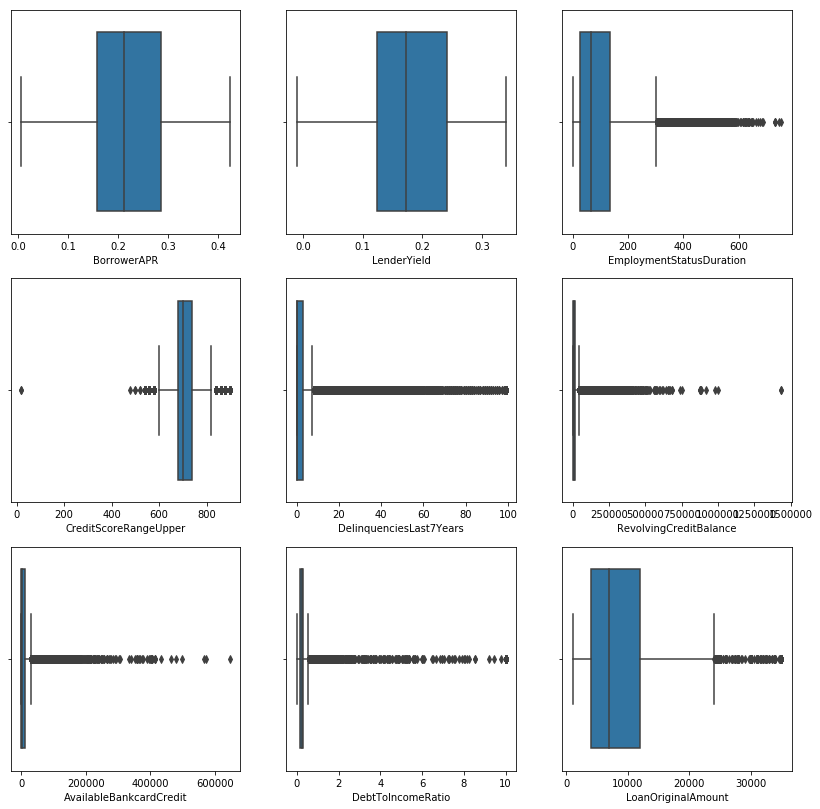

In [50]:
boxplotvarlist = ['BorrowerAPR','LenderYield','EmploymentStatusDuration','CreditScoreRangeUpper','DelinquenciesLast7Years','RevolvingCreditBalance','AvailableBankcardCredit','DebtToIncomeRatio','LoanOriginalAmount']
plt.figure(figsize=[14,14]);
for i,var in enumerate(boxplotvarlist):
    plt.subplot(3,3,i+1)
    sb.boxplot(data=loan_clean, x=var)

From the graph above it can be seen that some variables are really skewed, others are more evenly distributed. There is one though that seems to contain wrong values. **CreditScoreRangeUpper** seems to have unsually low values that I need to inspect. The other variables look somehow normal to me, so I will not inspect them further to look for outliers

In [51]:
loan_clean[loan_clean.CreditScoreRangeUpper < 250]

,CreditGrade,Term,LoanStatus,BorrowerAPR,LenderYield,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CreditScoreRangeUpper,DelinquenciesLast7Years,RevolvingCreditBalance,AvailableBankcardCredit,DebtToIncomeRatio,IncomeRange,LoanOriginalAmount
794,NC,36,Completed,0.29776,0.285,Not available,74,False,19,2,12039,0,0.25,Not displayed,4000
109468,NC,36,Completed,0.12700,0.105,Not available,74,False,19,2,12039,0,0.25,Not displayed,2550


This inspection shows that most parameters have been filled in with mean values as the originals were probably missing. The fact that CreditScoreRangeUpper contains doggy values suggests that perhaps the whole entry is not reliable. Let's remove these two entries from the cleaned dataset

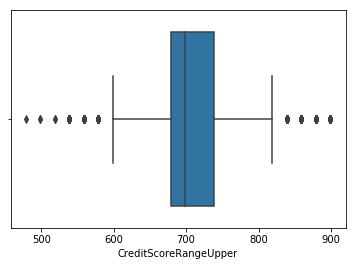

In [52]:
loan_clean.drop(loan_clean[loan_clean.CreditScoreRangeUpper < 250].index,axis=0,inplace=True)
sb.boxplot(data=loan_clean, x='CreditScoreRangeUpper');

Let's see what happens with non-numerical variables

In [53]:
loan_clean.describe(exclude = np.number)

,CreditGrade,Term,LoanStatus,EmploymentStatus,IsBorrowerHomeowner,IncomeRange
count,105520,105520,105520,105520,105520,105520
unique,8,3,12,8,2,8
top,C,36,Current,Employed,True,"$25,000-49,999"
freq,22642,79678,55730,66598,54523,31940


In [54]:
loan_clean.shape

(105520, 15)

There is nothing relevante on this front...
**Data wrangling has been completed** and now we have a clean data set to work with. In this data set there is a good mix of all data types seen throughout the course. As described before there are discrete and continuous values as well as ordinal and categorical data.

### What is the structure of your dataset?

> The cleaned data set contains 105,520 loans with 16 features for each loan. The features are a mix of numerical values, both continuous and discrete as well as categorical and ordinal variables.

### What is/are the main feature(s) of interest in your dataset?

> From a lender's point of view, the tricky bit is to determine the probability of default for a given loan as well as the APR to apply. Therefore the dependent variables in this case will be **BorrowerAPR** and **LoanStatus**. The other features I hope will be useful to estimate and characterize the former variables.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> As said before, any other feature than BorrowerAPR and LoanStatus will help support the analysis presented in this document

## Univariate Exploration

> Let's start with dependent variables. In this case BorrowerAPR. Let's analyse the variable on its own first before comparing it with others

In [55]:
loan_clean.BorrowerAPR.describe()

count    105520.000000
mean          0.220380
std           0.081034
min           0.006530
25%           0.157130
50%           0.211150
75%           0.285740
max           0.423950
Name: BorrowerAPR, dtype: float64

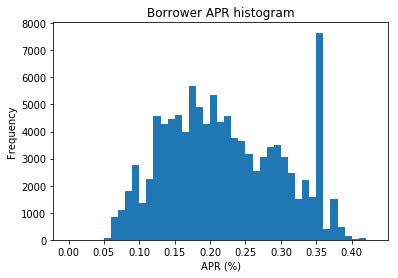

In [56]:
binsize = 0.01
binedges = np.arange(0,0.43+binsize,binsize)
plt.hist(loan_clean['BorrowerAPR'],bins=binedges);
plt.xticks(np.arange(0,0.45,0.05));
plt.title('Borrower APR histogram');
plt.xlabel('APR (%)');
plt.ylabel('Frequency');

The histogram above shows a somewhat right skewed distribution with a suprising spike at around 0.35 - 0.36 % interest. Let's inspect the data frame to check if we can see any pattern

In [57]:
loan_clean[(loan_clean['BorrowerAPR'] >= 0.35) & (loan_clean['BorrowerAPR'] < 0.36)].CreditGrade.value_counts()

HR    5284
E     2264
D       64
C       32
A        4
B        2
NC       2
AA       0
Name: CreditGrade, dtype: int64

Based on the ratings above, it seems that the algorithm that calculates the APR seems to be giving an interest rate of around 0.35 for all those customers with bad credit ratings.

Let's move now to analyze LoanStatus dependent variable.

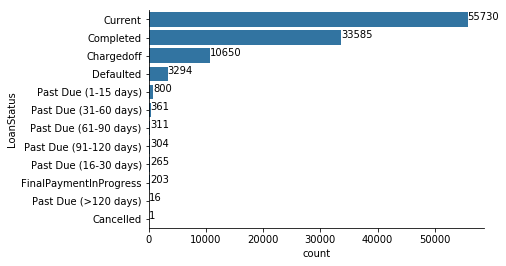

In [58]:
basecolor = sb.color_palette()[0]
nameorder = loan_clean.LoanStatus.value_counts().index
namevalue = loan_clean.LoanStatus.value_counts().values
sb.countplot(data=loan_clean,y='LoanStatus',color=basecolor,order=nameorder);
sb.despine()
for i,value in enumerate(namevalue):
    plt.text(value,i,value)

It seems that *Past Due (...)* does not give much information as numbers are relatively low compared to other categories. In principle all Past Due subcategories refer to the fact that payment is late. If this category was to be analysed on its own, perhaps it wouldn't make much sense to join all of them. However, since this is not the case and all of them suggest that the borrower is late on the payment, let's join all of them into one category. In this way the dataframe will be cleaner

In [59]:
loan_clean.LoanStatus.value_counts()

Current                   55730
Completed                 33585
Chargedoff                10650
Defaulted                  3294
Past Due (1-15 days)        800
Past Due (31-60 days)       361
Past Due (61-90 days)       311
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      203
Past Due (>120 days)         16
Cancelled                     1
Name: LoanStatus, dtype: int64

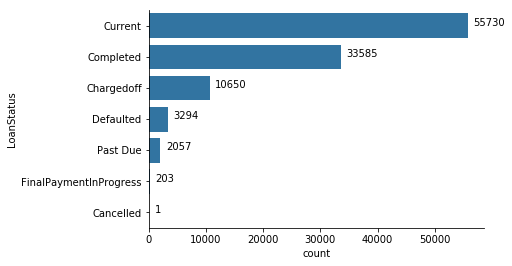

In [60]:
loan_clean.LoanStatus.replace(r'Past Due .+','Past Due',regex=True,inplace=True)
nameorder = loan_clean.LoanStatus.value_counts().index
namevalue = loan_clean.LoanStatus.value_counts().values
sb.countplot(data=loan_clean,y='LoanStatus',color=basecolor,order=nameorder);
sb.despine()
for i,value in enumerate(namevalue):
    plt.text(value+1000,i,value)

Let's analyse now the independent variables, starting with the categorical and ordinal ones.

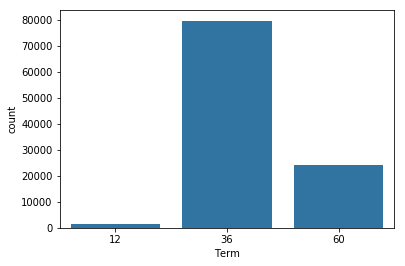

In [61]:
sb.countplot(data=loan_clean,x='Term',color=basecolor);

It can be seen above that 12-month loans are very unfrequent. Also, loans on 36 months are four times more frequent than those of 60. In order to simply the analysis let's keep only those loans with length 36 months as they seem to make the bulk of the analysis.

In [62]:
loan_clean.drop(loan_clean[loan_clean['Term'].isin([12,60])].index,axis=0,inplace=True)
loan_clean.drop('Term',axis=1,inplace=True)
loan_clean.columns

Index(['CreditGrade', 'LoanStatus', 'BorrowerAPR', 'LenderYield',
       'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner',
       'CreditScoreRangeUpper', 'DelinquenciesLast7Years',
       'RevolvingCreditBalance', 'AvailableBankcardCredit',
       'DebtToIncomeRatio', 'IncomeRange', 'LoanOriginalAmount'],
      dtype='object')

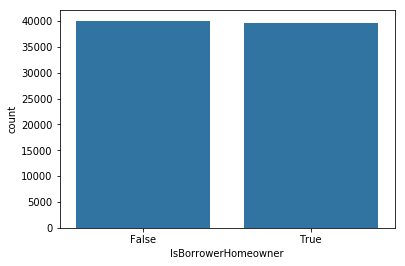

In [63]:
basecolor = sb.color_palette()[0]
sb.countplot(data=loan_clean, x='IsBorrowerHomeowner',color=basecolor)

The plot above clearly states that there number of loans is equally given to homeowners and no homeowners

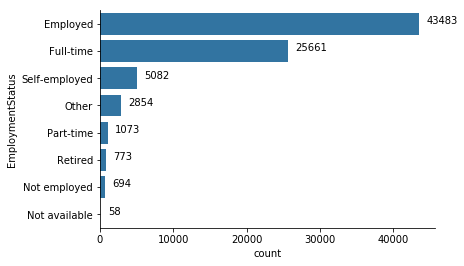

In [64]:
nameorder = loan_clean.EmploymentStatus.value_counts().index
namevalue = loan_clean.EmploymentStatus.value_counts().values
sb.countplot(data=loan_clean,y='EmploymentStatus',color=basecolor,order=nameorder);
sb.despine()
for i,value in enumerate(namevalue):
    plt.text(value+1000,i,value)

To me, the entry *Employed* results in information loss. The reason being that this category could be further broken down into either full-time or part-time. Also some categories have significantly smaller numbers than others. For example the number of retired people that got a loan in this data set is far smaller than people who are employed. Is this the true proportion of loans in reality or it's simply that retired people are not properly represented. Since I don't have a background on this topic and categories are misleading to me. Let's remove this variable altogether from the analysis. Also it makes sense to remove the numerical variable EmploymentStatusDuration since they are both related

In [65]:
loan_clean.drop(['EmploymentStatus','EmploymentStatusDuration'],axis=1,inplace=True)
loan_clean.columns

Index(['CreditGrade', 'LoanStatus', 'BorrowerAPR', 'LenderYield',
       'IsBorrowerHomeowner', 'CreditScoreRangeUpper',
       'DelinquenciesLast7Years', 'RevolvingCreditBalance',
       'AvailableBankcardCredit', 'DebtToIncomeRatio', 'IncomeRange',
       'LoanOriginalAmount'],
      dtype='object')

Let's proceed now with variable IncomeRange

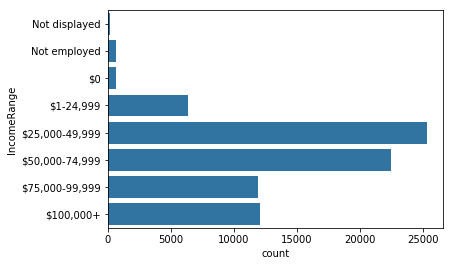

In [66]:
sb.countplot(data=loan_clean,y='IncomeRange',color=basecolor);

We can see above that most people getting loans have incomes between 25k and 75k dollars. There are very few loans given to Not Employed people. Also very few are given to people that do not earn anything. Let's remove these marginal categories to ease the analysis and plots. Results won't be affected since the bulk majority of data will still be present after the cleaning process

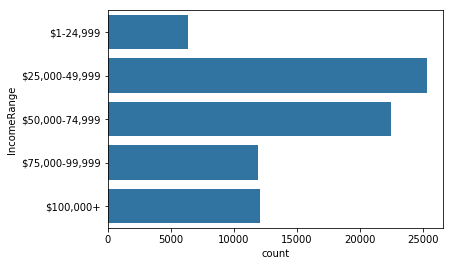

In [67]:
loan_clean.drop(loan_clean[loan_clean['IncomeRange'].isin(['Not displayed','Not employed','$0'])].index, axis=0, inplace=True )
# Rewrite IncomeRange category
ordinal_var_dict = {'IncomeRange':['$1-24,999','$25,000-49,999','$50,000-74,999','$75,000-99,999','$100,000+']}
for var in ordinal_var_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        loan_clean[var] = loan_clean[var].astype(ordered_var)
    else: # pre-v0.21
        loan_clean[var] = loan_clean[var].astype('category', ordered = True,
                                             categories = ordinal_var_dict[var])
        
sb.countplot(data=loan_clean,y='IncomeRange',color=basecolor);

Lastly, let's analyse the CreditGrade variable.

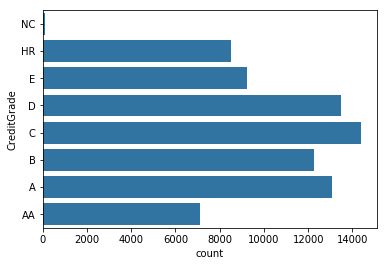

In [68]:
sb.countplot(data=loan_clean,y='CreditGrade',color=basecolor)

Again, it seems that NC does not add any value to the analysis. So let's remove it and make the data frame cleaner

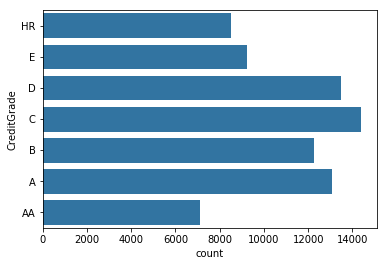

In [69]:
loan_clean.drop(loan_clean[loan_clean['CreditGrade'] == 'NC'].index, axis=0, inplace=True )
# Rewrite IncomeRange category
ordinal_var_dict = {'CreditGrade':['HR','E','D','C','B','A','AA']}
for var in ordinal_var_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        loan_clean[var] = loan_clean[var].astype(ordered_var)
    else: # pre-v0.21
        loan_clean[var] = loan_clean[var].astype('category', ordered = True,
                                             categories = ordinal_var_dict[var])
        
sb.countplot(data=loan_clean,y='CreditGrade',color=basecolor);

Let's now analyse the numerical independent variables starting with CreditScoreRangeUpper

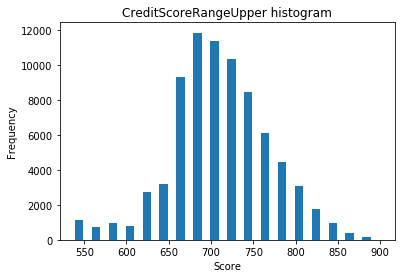

In [70]:
binsize = 10
binedges = np.arange(loan_clean['CreditScoreRangeUpper'].min(),loan_clean['CreditScoreRangeUpper'].max()+binsize,binsize)
plt.hist(loan_clean['CreditScoreRangeUpper'],bins=binedges);
plt.title('CreditScoreRangeUpper histogram');
plt.xlabel('Score');
plt.ylabel('Frequency');

Interestingly, it seems that credit score is given in steps of 20 starting from 9... Not sure what the reason for this is but it seems clear given the histogram above. Also the distribution seems to be normally distributed to the right but falls sharply on the left of the otherwise bell-curve. Let's use bins of 20, as this seems to be the pattern used by banks

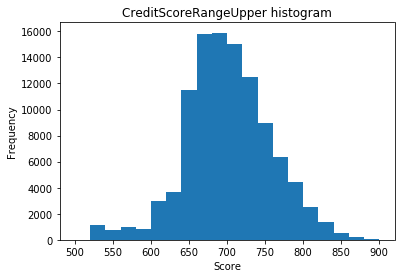

In [186]:
binsize = 20
binedges = np.arange(500,900+binsize,binsize)
plt.hist(loan_clean['CreditScoreRangeUpper'],bins=binedges);
plt.title('CreditScoreRangeUpper histogram');
plt.xlabel('Score');
plt.ylabel('Frequency');

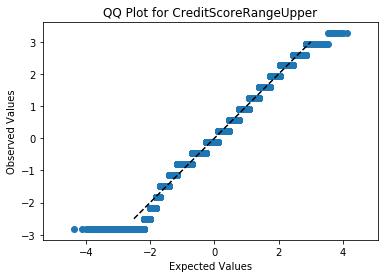

In [77]:
samp_mean = loan_clean['CreditScoreRangeUpper'].mean()
samp_sd = loan_clean['CreditScoreRangeUpper'].std()
n_points = loan_clean.shape[0]
qs = (np.arange(n_points) - .5) / n_points
expected_vals = norm.ppf(qs)
plt.scatter(expected_vals, (loan_clean['CreditScoreRangeUpper'].sort_values()-samp_mean)/samp_sd)
plt.plot([-2.5,3],[-2.5,3],'--', color = 'black')
plt.axis('equal')
plt.xlabel('Expected Values');
plt.ylabel('Observed Values');
plt.title('QQ Plot for CreditScoreRangeUpper');

The Q-Q plot above indicates what was postulated above. That is, data seems to be normally distributed on the right side of the centre, but this does not hold for the left side.
Let's now look at Delinquencies for the last 7 years

In [134]:
loan_clean['DelinquenciesLast7Years'].describe()

count    105520.000000
mean          3.928829
std           9.800297
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          99.000000
Name: DelinquenciesLast7Years, dtype: float64

Since the vast majority of deliquencies corresponds to no deliquencies, let's skip the value 0 to visualize the distribution

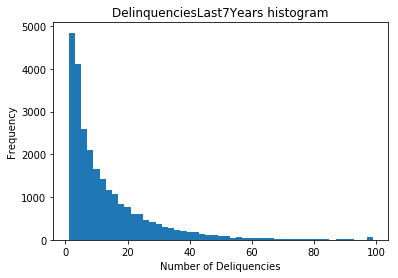

In [78]:
binsize = 2
binedges = np.arange(1,loan_clean['DelinquenciesLast7Years'].max()+binsize,binsize)
plt.hist(loan_clean['DelinquenciesLast7Years'],bins=binedges);
plt.title('DelinquenciesLast7Years histogram');
plt.xlabel('Number of Deliquencies');
plt.ylabel('Frequency');

The distribution above is extremely skewed to the right. Looking like an exponential distribution we can try using a logarithmic transformation to see if the transformed distribution approaches a normal distribution

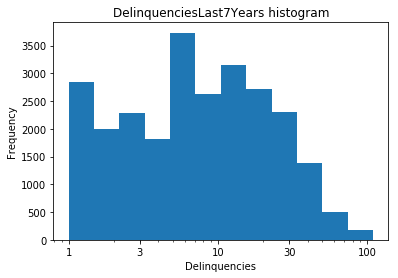

In [79]:
binsize = 0.17
binedges = 10**np.arange(0,np.log10(99)+binsize,binsize);
plt.hist(loan_clean['DelinquenciesLast7Years'],bins=binedges);
plt.title('DelinquenciesLast7Years histogram');
plt.xscale('log')
tick_locs = [1, 3, 10, 30, 100]
plt.xticks(tick_locs,tick_locs)
plt.xlabel('Delinquencies');
plt.ylabel('Frequency');

It seems that the transformed distribution does not show any signs of normality... We can then regard this variable to behave as an exponential distribution even though we have not performed any test to corroborate this hypothesis.
Let's see what happens with variable RevolvingCreditBalance

In [154]:
loan_clean['RevolvingCreditBalance'].describe()

count    1.055200e+05
mean     1.759220e+04
std      3.293691e+04
min      0.000000e+00
25%      3.102000e+03
50%      8.538000e+03
75%      1.952025e+04
max      1.435667e+06
Name: RevolvingCreditBalance, dtype: float64

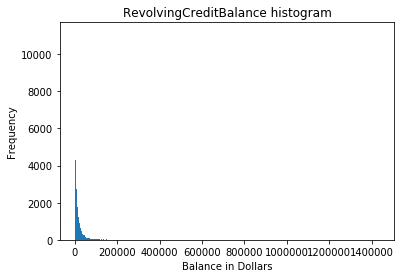

In [87]:
binsize = 1000
binedges = np.arange(0,loan_clean['RevolvingCreditBalance'].max()+binsize,binsize)
res = plt.hist(loan_clean['RevolvingCreditBalance'],bins=binedges);
plt.title('RevolvingCreditBalance histogram');
plt.xlabel('Balance in Dollars');
plt.ylabel('Frequency');

It can be seen that the above distribution is extremely right skewed with possibly some outliers. Let's zoom in the range 0-100K and see what the distribution looks like

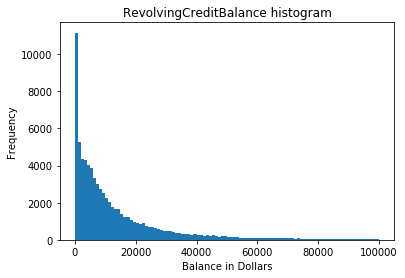

In [88]:
binsize = 1000
binedges = np.arange(0,100000+binsize,binsize)
res = plt.hist(loan_clean['RevolvingCreditBalance'],bins=binedges);
plt.title('RevolvingCreditBalance histogram');
plt.xlabel('Balance in Dollars');
plt.ylabel('Frequency');

Very similar to an exponential distribution with perhaps the peculiarity that 0 seems to be the most common value. Let's apply some log transformation to see what the resulting data looks like

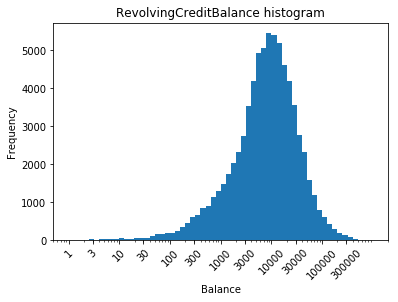

In [90]:
binsize = 0.1
binedges = 10**np.arange(0,np.log10(1000000)+binsize,binsize);
plt.hist(loan_clean['RevolvingCreditBalance'],bins=binedges);
plt.title('RevolvingCreditBalance histogram');
plt.xscale('log');
tick_locs = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000]
plt.xticks(tick_locs,tick_locs,rotation = 45);
plt.xlabel('Balance');
plt.ylabel('Frequency');

It seems that Revolving Credit Balances is log normally distributed with a slight skew to the left.    

As it can be seen below data from variable AvailableBankcardCredit, the distribution shown is very similar to Revolving Credit Balance

(0, 100000)

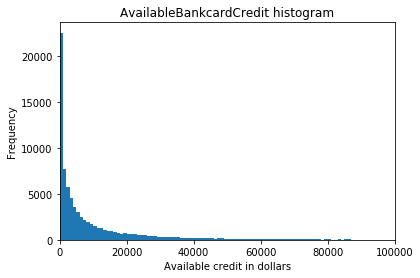

In [91]:
binsize = 1000
binedges = np.arange(0,loan_clean['AvailableBankcardCredit'].max()+binsize,binsize)
plt.hist(loan_clean['AvailableBankcardCredit'],bins=binedges);
plt.title('AvailableBankcardCredit histogram');
plt.xlabel('Available credit in dollars');
plt.ylabel('Frequency');
plt.xlim((0,100000))

Now, tranforming the data

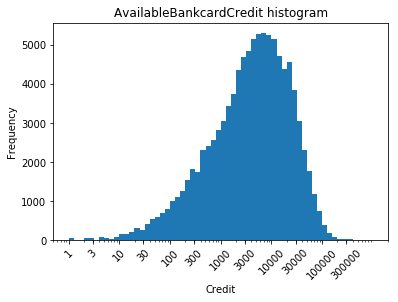

In [184]:
binsize = 0.1
binedges = 10**np.arange(0,np.log10(1000000)+binsize,binsize);
plt.hist(loan_clean['AvailableBankcardCredit'],bins=binedges);
plt.title('AvailableBankcardCredit histogram');
plt.xscale('log');
tick_locs = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000]
plt.xticks(tick_locs,tick_locs,rotation = 45);
plt.xlabel('Credit');
plt.ylabel('Frequency');

As expected the transformed data follows a similar distribution as the one seen for the previous variable. It's somewhat normally distributed with a skew to the left.

Let's now look at LoanOriginalAmount. Let's make the bin size small to find out whether there are standard loans or loans that are more often asked for

(0, 40000)

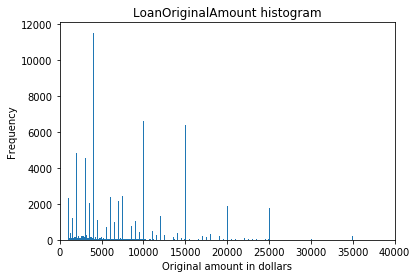

In [97]:
binsize = 100
binedges = np.arange(0,loan_clean['LoanOriginalAmount'].max()+binsize,binsize)
histRet=plt.hist(loan_clean['LoanOriginalAmount'],bins=binedges);
plt.title('LoanOriginalAmount histogram');
plt.xlabel('Original amount in dollars');
plt.ylabel('Frequency');
plt.xlim((0,40000))

Below we can see which are the most common loan amounts asked for. This is inline with the spikes in the graph above

In [100]:
freqVal =[i for i in zip(histRet[0],histRet[1])]
[i[1] for i in sorted(freqVal,reverse=True)[0:10]]

[4000, 10000, 15000, 5000, 2000, 3000, 2500, 7500, 6000, 1000]

When analysing LendeYield I expect to find a very similar data distribution as the one found for BorrowerAPR. The reason is that the Lender will try to assign the same Risk-Reward strategy. Let's see what happens

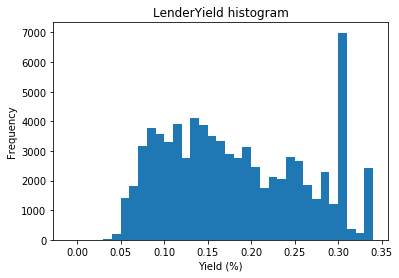

In [99]:
binsize = 0.01
binedges = np.arange(loan_clean['LenderYield'].min(),loan_clean['LenderYield'].max()+binsize,binsize)
plt.hist(loan_clean['LenderYield'],bins=binedges);
plt.title('LenderYield histogram');
plt.xlabel('Yield (%)');
plt.ylabel('Frequency');

The plot above confirms the hypothesis laid above. Lastly, let's look at variable DebtToIncomeRatio

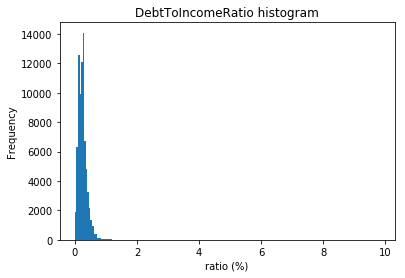

In [106]:
binsize = 0.05
binedges = np.arange(0,loan_clean['DebtToIncomeRatio'].max()+binsize,binsize)
plt.hist(loan_clean['DebtToIncomeRatio'],bins=binedges);
plt.title('DebtToIncomeRatio histogram');
plt.xlabel('ratio (%)');
plt.ylabel('Frequency');

It can be observed that the vast majority of data points is confined between 0 and 1. The fact that the axis go up to 10 indicate clear outliers. Let's perform a logarithmic transformation to find out more about the distribution

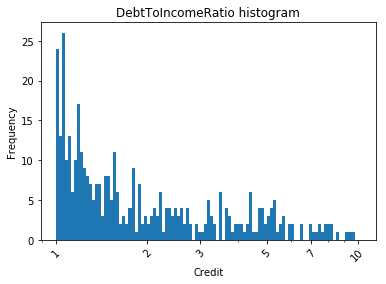

In [107]:
binsize = 0.01
binedges = 10**np.arange(0,np.log10(10.01)+binsize,binsize);
plt.hist(loan_clean['DebtToIncomeRatio'],bins=binedges);
plt.title('DebtToIncomeRatio histogram');
plt.xscale('log');
tick_locs = [1, 2, 3, 5, 7, 10]
plt.xticks(tick_locs,tick_locs,rotation = 45);
plt.xlabel('Credit');
plt.ylabel('Frequency');

In [241]:
loan_clean[loan_clean['DebtToIncomeRatio'] > 10].sample(10)

,CreditGrade,Term,LoanStatus,BorrowerAPR,LenderYield,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CreditScoreRangeUpper,DelinquenciesLast7Years,RevolvingCreditBalance,AvailableBankcardCredit,DebtToIncomeRatio,IncomeRange,LoanOriginalAmount,MonthlyLoanPayment
90975,C,36,Completed,0.16115,0.1440,Not employed,0,False,679,0,32593,3036,10.01,Not employed,13995,0.00
52771,C,36,Completed,0.28269,0.2600,Full-time,37,False,679,2,17053,9604,10.01,"$1-24,999",8100,320.83
26112,HR,36,Completed,0.35643,0.3099,Full-time,81,False,679,9,1648,955,10.01,"$1-24,999",2200,95.81
55170,B,36,Completed,0.29274,0.2600,Full-time,53,True,699,0,3669,13052,10.01,"$1-24,999",7500,312.26
95890,A,36,Current,0.15324,0.1149,Employed,44,False,759,3,2092,2713,10.01,"$1-24,999",5225,174.77
68980,AA,36,Completed,0.10692,0.0950,Full-time,49,True,799,0,0,0,10.01,Not displayed,5000,161.34
89875,D,36,Chargedoff,0.22945,0.2020,Self-employed,181,True,639,0,5467,4212,10.01,"$1-24,999",9740,372.98
37625,HR,36,Completed,0.16386,0.1295,Not employed,1,False,539,0,0,0,10.01,Not employed,2050,71.01
92399,E,36,Current,0.35244,0.3060,Employed,64,False,659,0,2474,2508,10.01,"$1-24,999",7500,324.99
34883,C,36,Current,0.23939,0.1919,Other,334,False,719,0,20671,7992,10.01,"$1-24,999",14500,540.28


Not really sure how to interpret this, but the scaled plot shows an interesting fact. There are many people with a debt to income ratio of 10.01. Given the log distribution above it seems very unlikely that all these people share the same ratio... To me this looks like the ratio has been clipped on the top. The fact that it's clipped provides uncertainty about the real distribution, this is actually an information loss. I think the safest will be to remove these entries as they look bogus at least on one variable

In [102]:
loan_clean.drop(loan_clean[loan_clean['DebtToIncomeRatio'] > 10].index,axis=0,inplace=True)

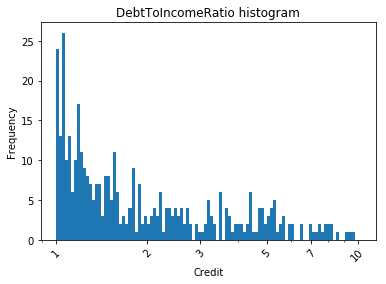

In [103]:
binsize = 0.01
binedges = 10**np.arange(0,np.log10(10.01)+binsize,binsize);
plt.hist(loan_clean['DebtToIncomeRatio'],bins=binedges);
plt.title('DebtToIncomeRatio histogram');
plt.xscale('log');
tick_locs = [1, 2, 3, 5, 7, 10]
plt.xticks(tick_locs,tick_locs,rotation = 45);
plt.xlabel('Credit');
plt.ylabel('Frequency');

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> BorrowersAPR shows a somewhat normal distribution with a slight skew to the right. There is a spike of interest around 35% suggesting that bank's perceived risk for a big number of loans is the same. The other dependent variable LoanStatus, we've seen that some of its categories were very scarcely populated and so I decided to combine a few of them into one to make that category more relevant.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> From the categorical/ordinal features analysed, one of them was removed as it was deemed that its categories were not relevant enough for the analysis. Credit grade and Income Range were cleaned after visual inspection. Employment status was also removed as the quality of the data was poor and hard to interpret. As far as the numerical features are concerned. There was a few interesting aspects to note. For example, after visual inspection it was observed that DebtToIncomeRation had to be cleaned. Also, transforming logarithmically some distributions seemed to give a more normally looking distribution. However this transformation was not successful for every feature that was transformed. Making the bin size small, gave good results with feature LoanOriginalAmount and revealed a few spikes that showcase the most common loan amounts. Lastly, the Q-Q analysis in feature CreditScoreRangeUpper showed that this feature shows normality for the right side of the bell curve and not quite normal for the left side.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!